# Vulnerable Function Identification + Reachability PoC

Current vulnerability reports require a lot of manual triaging to understand if a project is impacted. How can we automate this process?

<img src="./docs/imgs/VulnScans.png" alt="VulnScans" width="1000"/>

### Questions we need to ask:
* What are the package dependency chains?
* What functions are being called in the dependency chain?
* Where are the vulnerable functions associated with the CVE?

<img src="./docs/imgs/ReachabilityScans.png" alt="ReachabilityScans" width="1000"/>

In [1]:
import os
import pandas as pd
import json
from utils import codeql_helper, osv_helper, sbom_helper, git_helper

### Example Vulnerability for this PoC

Traefik Advisories: https://github.com/wolfi-dev/advisories/blob/main/traefik.advisories.yaml

Example CVE: CVE-2022-40716

GHSA Link: https://github.com/advisories/GHSA-m69r-9g56-7mv8

### Parse the Advisory to obtian the vulnerability fixing commit (VFC)

Prefer to parse the GHSA advisory, or any advisory in [OSV format](https://ossf.github.io/osv-schema/).

The point of the VFC, will show how a vulnerability was fixed. Generally, these point back to the associated GitHub repository. The VFC allows us to identify the following properties around the CVE: the base repository, and the commit to fix the vulnerability. 

If an advisory is missing a VFC, see VFCFinder: https://github.com/s3c2/vfcfinder

In [3]:
report, report_df, report_vfc = osv_helper.parse_osv(osv_json_filename="./example_data/GHSA-m69r-9g56-7mv8.json")

print(f"Associated package for CVE: \n{report_df[['package.ecosystem', 'package.name', 'introduced', 'fixed']]}\n")

# print the assocaiated VFCs for the report
if len(report_vfc)>0:
    for idx, row in report_vfc.iterrows():
        print(f"VFC {idx+1}/{len(report_vfc)} for {report['aliases'][0]}: \n"
              f"    - url: {row['url']}\n"
              f"    - repo_owner: {row['repo_owner']}\n"
              f"    - repo_name: {row['repo_name']}\n"
              f"    - sha: {row['sha']}")

Associated package for CVE: 
  package.ecosystem                 package.name introduced   fixed
0                Go  github.com/hashicorp/consul          0  1.11.9
1                Go  github.com/hashicorp/consul     1.12.0  1.12.5
2                Go  github.com/hashicorp/consul     1.13.0  1.13.2

VFC 1/1 for CVE-2022-40716: 
    - url: https://github.com/hashicorp/consul/commit/ae822d752ad36007e353249691a0ef318cf55d08
    - repo_owner: hashicorp
    - repo_name: consul
    - sha: ae822d752ad36007e353249691a0ef318cf55d08


## Build the SBOM for the target software

Container SBOMs today appear to be flat and are missing the language dependencies. 
For this PoC we will rely on [opensbom-generator/spdx-sbom-generator](https://github.com/opensbom-generator/spdx-sbom-generator), which has the ability 

In [4]:
# generate the SBOM
sbom_helper.generate_go_sbom(target_dir="/home/td/Documents/GitHub/traefik", 
                             output_loc=f"{os.getcwd()}/example_data/SBOM/traefik_test")

INFO[2023-08-02T13:11:02-04:00] Starting to generate SPDX ...                
INFO[2023-08-02T13:11:02-04:00] Running generator for Module Manager: `go-mod` with output `/home/td/Documents/GitHub/vulnerable-functions/example_data/SBOM/traefik_test/bom-go-mod.spdx` 
INFO[2023-08-02T13:11:02-04:00] Current Language Version go version go1.20.5 linux/amd64 
INFO[2023-08-02T13:11:02-04:00] Global Setting File                          
INFO[2023-08-02T13:11:09-04:00] Command completed successful for below package managers 
INFO[2023-08-02T13:11:09-04:00] Plugin go-mod generated output at /home/td/Documents/GitHub/vulnerable-functions/example_data/SBOM/traefik_test/bom-go-mod.spdx 


## Build the dependency graph of the target SBOM

Allows us to understand how packages within the target software interact.

More info on dependency graphs: [Wikipedia: Dependency Graph](https://en.wikipedia.org/wiki/Dependency_graph), [GitHub Docs: About the dependency graph](https://docs.github.com/en/code-security/supply-chain-security/understanding-your-software-supply-chain/about-the-dependency-graph)

In [5]:
# convert the SBOM to a graph
graph = sbom_helper.convert_sbom2graph(f"{os.getcwd()}/example_data/SBOM/traefik_test/bom-go-mod.spdx")

# get the roots of the graph
root_node = [v for v, d in graph.in_degree() if d == 0]

print(str(graph))
print(f"Graph roots: {root_node}")

DiGraph named 'sbom' with 305 nodes and 1900 edges
Graph roots: ['github.com/traefik/traefik/v3']


## Simple demonstration of Directed Graphs (DiGraphs)

A dependency graph is a [directed graph](https://en.wikipedia.org/wiki/Directed_graph).

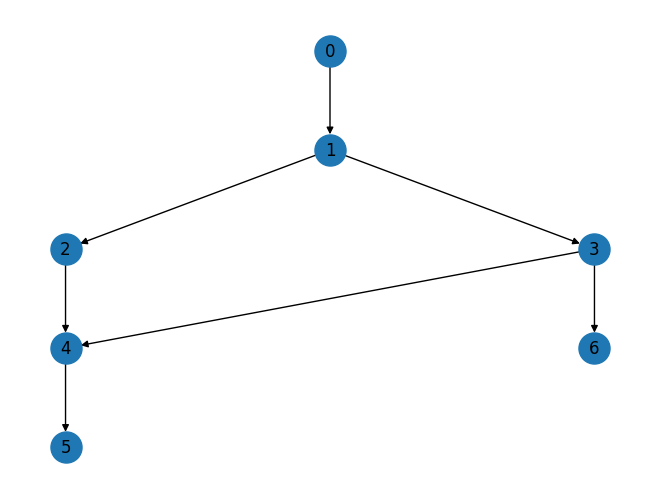

In [6]:
import networkx as nx
from networkx.drawing import nx_agraph
import pygraphviz
import warnings
warnings.filterwarnings('ignore')

# generate a dot format
dot_format = """
        digraph G {
            0 -> 1;
            1 -> 2;
            1 -> 3;
            2 -> 4;
            3 -> 4;
            4 -> 5;
            3 -> 6;
        }
    """

# convert the string to a graph
sample_graph = nx_agraph.from_agraph(pygraphviz.AGraph(dot_format))

# draw the graph
pos = nx.nx_pydot.pydot_layout(sample_graph, prog="dot")
nx.draw(sample_graph, pos=pos, with_labels = True, node_size = 500, width = 1, linewidths = 1)

In [7]:
print(f"Possible paths: ")
sbom_helper.dependency_paths(temp_graph=sample_graph,
                             source_node='0',
                             target_node='5')

Possible paths: 
['0', '1', '2', '4', '5']
['0', '1', '3', '4', '5']


## Back to the SBOM Graph for Traefik

It's not pretty...

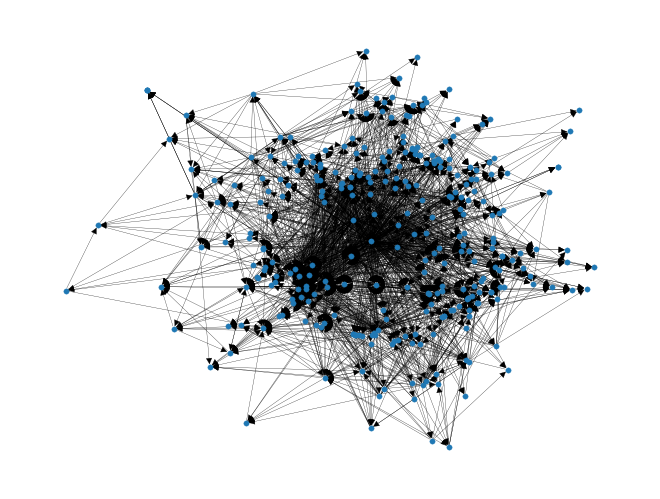

In [8]:
import networkx as nx
# draw the graph
nx.draw_kamada_kawai(graph, with_labels = False, node_size = 15, width = 0.2, linewidths = 0.2)

## Identify all possible paths that point to the vulnerable dependency with the CVE (i.e., github.com/hashicorp/consul)

In [9]:
print(f"Source Node: {root_node}")

# we set the target node as the package containing the vulnerability
target_node = report['package_name']
print(f"Target Node: {target_node}\n")

print(f"Possible paths from {root_node[0]} -> {target_node}:")
sbom_helper.dependency_paths(temp_graph=graph,
                             source_node=root_node[0],
                             target_node=target_node)

Source Node: ['github.com/traefik/traefik/v3']
Target Node: github.com/hashicorp/consul

Possible paths from github.com/traefik/traefik/v3 -> github.com/hashicorp/consul:
['github.com/traefik/traefik/v3', 'github.com/hashicorp/consul']


['github.com/traefik/traefik/v3', 'github.com/hashicorp/consul'] denotes a direct dependency. 

Which can be verified from the [go.mod](https://github.com/traefik/traefik/blob/master/go.mod#L29) file of Traefik. 

# Extract the vulnerable function of the CVE

* Clone the repo
* Parse the patch link
* Extract the changed functions (i.e., vulnerable functions) from the patch link, relies on CodeQL. 
* Identify entry points within the package that point to the vunlerable functions.

In [10]:
# set some variables to make it easier
REPO_OWNER = report_vfc.iloc[0]["repo_owner"]
REPO_NAME = report_vfc.iloc[0]["repo_name"]
CLONE_PATH = "/home/td/Documents/NCSU/2023_Summer/go_clones/"
REPO_PATH = f"{CLONE_PATH}{REPO_OWNER}/{REPO_NAME}/"

# clone the repository from the CVE report, can rely on the report_vfc
git_helper.clone_repo(repo_owner=REPO_OWNER, 
                      repo_name=REPO_NAME, 
                      clone_path=CLONE_PATH)

Path already exists: /home/td/Documents/NCSU/2023_Summer/go_clones/hashicorp/consul


#### Parsing the commit relies on PatchParser

PyPi package for parsing GitHub Commits (PatchParser): https://github.com/tdunlap607/patchparser

In [11]:
# obtain the git diff of the vfc
vfc_diff = git_helper.git_diff(
    clone_path=REPO_PATH,
    commit_sha=report_vfc.iloc[0]['sha'],
    df=True
)

vfc_diff[['file_name', 'original_modified_lines', 'new_modified_lines']]

,file_name,original_modified_lines,new_modified_lines
0,.changelog/14579.txt,None,"[1, 2, 3]"
1,agent/consul/auto_config_endpoint.go,"[409, 410, 411]","[409, 410, 411, 412, 413, 414]"
2,agent/consul/auto_config_endpoint_test.go,None,"[4, 5, 6, 9, 14]"
3,agent/consul/auto_config_endpoint_test.go,None,"[884, 885, 886, 887, 888, 889, 890, 891, 892, ..."
4,agent/consul/leader_connect_ca.go,None,"[1400, 1401, 1402, 1403, 1404, 1405, 1406, 140..."
5,agent/consul/leader_connect_ca_test.go,"[484, 485]","[484, 485, 486]"


#### Using CodeQL to extract functions and build call graphs from the vulnerable package

* Checkout the commit
* Build the CodeQL DB
* Run our custom CodeQL queries to extract the function information

In [12]:
CODEQL_DB_PATH = "/home/td/Documents/NCSU/2023_Summer/go_codeql_dbs/"
CODEQL_OUTPUT = "/home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_output/"
BASE_PATH = "/home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/"

# checkout the commit
git_helper.git_checkout_commit(
    clone_path=REPO_PATH,
    commit_sha=report_vfc.iloc[0]['sha'],
)

# build the CodeQL DB
codeql_helper.build_db(
    package_path=REPO_PATH,
    output_db_path=f"{CODEQL_DB_PATH}{report['id']}__{REPO_OWNER}__{REPO_NAME}__{report_vfc.iloc[0]['sha']}",
)

# run the custom CodeQL Query to get all function within a module
temp_functions = codeql_helper.run_codeql(
    output_db_path=f"{CODEQL_DB_PATH}{report['id']}__{REPO_OWNER}__{REPO_NAME}__{report_vfc.iloc[0]['sha']}",
    output_file_name=f"{CODEQL_OUTPUT}{report['id']}__{REPO_OWNER}__{REPO_NAME}__{report_vfc.iloc[0]['sha']}",
    custom_query_path=f"{BASE_PATH}codeql_queries/extract_functions_module.ql",
)


# run the custom CodeQL Query to get the call graph of a module
temp_cg = codeql_helper.run_codeql(
    output_db_path=f"{CODEQL_DB_PATH}{report['id']}__{REPO_OWNER}__{REPO_NAME}__{report_vfc.iloc[0]['sha']}",
    output_file_name=f"{CODEQL_OUTPUT}{report['id']}__{REPO_OWNER}__{REPO_NAME}__{report_vfc.iloc[0]['sha']}__call_graph",
    custom_query_path=f"{BASE_PATH}codeql_queries/call_graph.ql",
)

# remove complete filepath from all the functions for easy reading
temp_functions['funcFile'] = temp_functions.apply(
    lambda x: x['funcFile'].replace(CLONE_PATH,''),
    axis=1
)

temp_functions['funcLocation'] = temp_functions.apply(
    lambda x: x['funcLocation'].replace(CLONE_PATH,''),
    axis=1
)

temp_cg['callerLocation'] = temp_cg.apply(
    lambda x: x['callerLocation'].replace(CLONE_PATH,''),
    axis=1
)

temp_cg['calleeFunctionFile'] = temp_cg.apply(
    lambda x: x['calleeFunctionFile'].replace(CLONE_PATH,''),
    axis=1
)

temp_cg['callerFunctionFile'] = temp_cg.apply(
    lambda x: x['callerFunctionFile'].replace(CLONE_PATH,''),
    axis=1
)

CodeQL DB /home/td/Documents/NCSU/2023_Summer/go_codeql_dbs/GHSA-m69r-9g56-7mv8__hashicorp__consul__ae822d752ad36007e353249691a0ef318cf55d08 already exists.


Compiling query plan for /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/extract_functions_module.ql.
[1/1] Found in cache: /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/extract_functions_module.ql.
Starting evaluation of codeql/go-queries/extract_functions_module.ql.
[1/1 eval 2.6s] Evaluation done; writing results to /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_output/GHSA-m69r-9g56-7mv8__hashicorp__consul__ae822d752ad36007e353249691a0ef318cf55d08.bqrs.
Shutting down query evaluator.
Compiling query plan for /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/call_graph.ql.
[1/1] Found in cache: /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/call_graph.ql.
Starting evaluation of codeql/go-queries/call_graph.ql.
[1/1 eval 8.2s] Evaluation done; writing results

### Fully Qualified Names Workaround

I ran into some issues with extracting the fully qualified names with CodeQL, so I take the {function name}\_{file of function}\_{line start of function} to create a unique function.

Future work will be on extracting the exact fully qualified function names.

In [13]:
temp_cg['uniqueCallee'] = temp_cg.apply(
    lambda x: f"{x['calleeFunction']}_{x['calleeFunctionFile']}_{x['calleeFunctionStartLine']}",
    axis=1
)

temp_cg['uniqueCaller'] = temp_cg.apply(
    lambda x: f"{x['callerFunction']}_{x['callerFunctionFile']}_{x['callerFunctionStartLine']}",
    axis=1
)

temp_functions['uniqueFunction'] = temp_functions.apply(
    lambda x: f"{x['functionName']}_{x['funcFile']}_{x['funcStartLine']}",
    axis=1
)

In [14]:
temp_functions.head()

,funcFile,functionName,funcStartLine,funcEndLine,funcNumLines,functionQualifiedName,funcLocation,uniqueFunction
0,hashicorp/consul/acl/errors.go,Error,68,73,1,github.com/hashicorp/consul/acl.PermissionDeni...,hashicorp/consul/acl/errors.go@68:1:73:1,Error_hashicorp/consul/acl/errors.go_68
1,hashicorp/consul/acl/errors.go,IsErrDisabled,54,56,1,github.com/hashicorp/consul/acl.IsErrDisabled,hashicorp/consul/acl/errors.go@54:1:56:1,IsErrDisabled_hashicorp/consul/acl/errors.go_54
2,hashicorp/consul/acl/errors.go,IsErrNotFound,42,44,1,github.com/hashicorp/consul/acl.IsErrNotFound,hashicorp/consul/acl/errors.go@42:1:44:1,IsErrNotFound_hashicorp/consul/acl/errors.go_42
3,hashicorp/consul/acl/errors.go,IsErrPermissionDenied,60,62,1,github.com/hashicorp/consul/acl.IsErrPermissio...,hashicorp/consul/acl/errors.go@60:1:62:1,IsErrPermissionDenied_hashicorp/consul/acl/err...
4,hashicorp/consul/acl/errors.go,IsErrRootDenied,48,50,1,github.com/hashicorp/consul/acl.IsErrRootDenied,hashicorp/consul/acl/errors.go@48:1:50:1,IsErrRootDenied_hashicorp/consul/acl/errors.go_48


In [15]:
temp_cg.head()

,callerFunction,callerLocation,callerFunctionFile,callerFunctionStartLine,calleeFunction,calleeFunctionFile,calleeFunctionStartLine,calleeFunctionEndLineTest,uniqueCallee,uniqueCaller
0,Format,hashicorp/consul/command/snapshot/inspect/form...,hashicorp/consul/command/snapshot/inspect/form...,41,ByteSize,hashicorp/consul/command/snapshot/inspect/form...,101,101,ByteSize_hashicorp/consul/command/snapshot/ins...,Format_hashicorp/consul/command/snapshot/inspe...
1,Error,hashicorp/consul/agent/structs/txn.go@154:1:160:1,hashicorp/consul/agent/structs/txn.go,154,Error,hashicorp/consul/agent/structs/txn.go,128,128,Error_hashicorp/consul/agent/structs/txn.go_128,Error_hashicorp/consul/agent/structs/txn.go_154
2,Error,hashicorp/consul/command/exec/exec.go@680:1:682:1,hashicorp/consul/command/exec/exec.go,680,prefixLines,hashicorp/consul/command/exec/exec.go,684,684,prefixLines_hashicorp/consul/command/exec/exec...,Error_hashicorp/consul/command/exec/exec.go_680
3,Error,hashicorp/consul/sdk/testutil/retry/retry.go@6...,hashicorp/consul/sdk/testutil/retry/retry.go,60,log,hashicorp/consul/sdk/testutil/retry/retry.go,77,77,log_hashicorp/consul/sdk/testutil/retry/retry....,Error_hashicorp/consul/sdk/testutil/retry/retr...
4,Write,hashicorp/consul/agent/remote_exec.go@70:1:99:1,hashicorp/consul/agent/remote_exec.go,70,Flush,hashicorp/consul/agent/remote_exec.go,101,101,Flush_hashicorp/consul/agent/remote_exec.go_101,Write_hashicorp/consul/agent/remote_exec.go_70


### Identify the functions changed in the VFC

Relies on the modified lines from the patch link. 

Take our example: 

In [16]:
# changed files and line numbers
changed_files = (
    vfc_diff.groupby("file_name")
    .agg({"new_modified_lines": "sum"})
    .reset_index(drop=False)
)

# match functions to the changed_files, complete for each line
vulnerable_functions = pd.DataFrame()

# check each file and the changed line numbers to get the matching functions
for idx, file in changed_files.iterrows():
    temp = git_helper.match_functions(
        temp_functions=temp_functions.copy(),
        temp_file_name=file.file_name,
        temp_lines=file.new_modified_lines,
    )

    vulnerable_functions = pd.concat([vulnerable_functions, temp])

vulnerable_functions

,funcFile,functionName,funcStartLine,funcEndLine,funcNumLines,functionQualifiedName,funcLocation,uniqueFunction,file_name,line
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,409
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,410
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,411
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,412
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,413
7550,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,1,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,agent/consul/auto_config_endpoint.go,414
8182,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate,1392,1539,1,github.com/hashicorp/consul/agent/consul.CAMan...,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate_hashicorp/consul/agent/consul/...,agent/consul/leader_connect_ca.go,1400
8182,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate,1392,1539,1,github.com/hashicorp/consul/agent/consul.CAMan...,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate_hashicorp/consul/agent/consul/...,agent/consul/leader_connect_ca.go,1401
8182,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate,1392,1539,1,github.com/hashicorp/consul/agent/consul.CAMan...,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate_hashicorp/consul/agent/consul/...,agent/consul/leader_connect_ca.go,1402
8182,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate,1392,1539,1,github.com/hashicorp/consul/agent/consul.CAMan...,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate_hashicorp/consul/agent/consul/...,agent/consul/leader_connect_ca.go,1403


In [17]:
# get a set of unique changed functions
unique_vulnerable_functions = (
    vulnerable_functions[
        [
            "funcFile",
            "functionName",
            "funcStartLine",
            "funcEndLine",
            "file_name",
            "functionQualifiedName",
            "funcLocation",
            "uniqueFunction"
        ]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

unique_vulnerable_functions["id"] = report['id']
unique_vulnerable_functions["repo_owner"] = REPO_OWNER
unique_vulnerable_functions["repo_name"] = REPO_NAME
unique_vulnerable_functions["vfc_sha"] = report_vfc.iloc[0]['sha']

unique_vulnerable_functions

,funcFile,functionName,funcStartLine,funcEndLine,file_name,functionQualifiedName,funcLocation,uniqueFunction,id,repo_owner,repo_name,vfc_sha
0,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR,402,429,agent/consul/auto_config_endpoint.go,github.com/hashicorp/consul/agent/consul.parse...,hashicorp/consul/agent/consul/auto_config_endp...,parseAutoConfigCSR_hashicorp/consul/agent/cons...,GHSA-m69r-9g56-7mv8,hashicorp,consul,ae822d752ad36007e353249691a0ef318cf55d08
1,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate,1392,1539,agent/consul/leader_connect_ca.go,github.com/hashicorp/consul/agent/consul.CAMan...,hashicorp/consul/agent/consul/leader_connect_c...,SignCertificate_hashicorp/consul/agent/consul/...,GHSA-m69r-9g56-7mv8,hashicorp,consul,ae822d752ad36007e353249691a0ef318cf55d08


## Identify entry points of the vulnerable package to the vulnerable functions

Relies on the call graph from above.

Further validation in this PR that we detect the vulnerable entry point of ConnectCA.Sign: https://github.com/hashicorp/consul/pull/14579

"Added URI length checks to ConnectCA CSR requests. Prior to this change, it was possible for a malicious actor to designate multiple SAN URI values in a call to the ***ConnectCA.Sign*** endpoint. The endpoint now only allows for exactly one SAN URI to be specified."

In [18]:
### CALL GRAPH Analysis
# convert to directed edge list
cg_list = temp_cg[["uniqueCaller", "uniqueCallee"]].values.tolist()
# convert to a list of tuples (necessary for networkx)
cg_tuple = [tuple(x) for x in cg_list]

# converted the edge list to a DirectedGraph
# https://networkx.org/documentation/stable/reference/classes/digraph.html
G_nx = nx.DiGraph(cg_tuple)

# placeholder for function ancestors
temp_ancestors = []

# placeholder for function entryPoint ancestors
temp_entry_ancestors = []

# conver functionNames to a list
temp_func = unique_vulnerable_functions.uniqueFunction.values.tolist()

# loop through each extract function to obtain the ancestors
for idx, func in enumerate(temp_func):
    # Obtain the ancestors (Returns all nodes having a path to source in G.)
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.ancestors.html
    # this a reverse breadth-first-search
    try:
        print(func)
        func_ancestors = list(nx.ancestors(G_nx, func))
        print(func_ancestors)
        temp_ancestors.extend(func_ancestors)

    except Exception as e:
        print(str(e))
        func_ancestors = []
        temp_ancestors.extend(func_ancestors)

# set the vulnerable entry points
vulnerable_entry = pd.merge(temp_functions, pd.DataFrame(temp_ancestors, columns=['uniqueFunction']),
                            on="uniqueFunction",
                            how="inner")

vulnerable_entry

parseAutoConfigCSR_hashicorp/consul/agent/consul/auto_config_endpoint.go_402
['Authorize_hashicorp/consul/agent/consul/auto_config_endpoint.go_63']
SignCertificate_hashicorp/consul/agent/consul/leader_connect_ca.go_1392
['Sign_hashicorp/consul/agent/consul/auto_encrypt_endpoint.go_18', 'Sign_hashicorp/consul/agent/consul/connect_ca_endpoint.go_136', 'SignCertificate_hashicorp/consul/agent/consul/auto_config_backend.go_23']


,funcFile,functionName,funcStartLine,funcEndLine,funcNumLines,functionQualifiedName,funcLocation,uniqueFunction
0,hashicorp/consul/agent/consul/auto_config_back...,SignCertificate,23,25,1,github.com/hashicorp/consul/agent/consul.autoC...,hashicorp/consul/agent/consul/auto_config_back...,SignCertificate_hashicorp/consul/agent/consul/...
1,hashicorp/consul/agent/consul/auto_config_endp...,Authorize,63,139,1,github.com/hashicorp/consul/agent/consul.jwtAu...,hashicorp/consul/agent/consul/auto_config_endp...,Authorize_hashicorp/consul/agent/consul/auto_c...
2,hashicorp/consul/agent/consul/auto_encrypt_end...,Sign,18,54,1,github.com/hashicorp/consul/agent/consul.AutoE...,hashicorp/consul/agent/consul/auto_encrypt_end...,Sign_hashicorp/consul/agent/consul/auto_encryp...
3,hashicorp/consul/agent/consul/connect_ca_endpo...,Sign,136,201,1,github.com/hashicorp/consul/agent/consul.Conne...,hashicorp/consul/agent/consul/connect_ca_endpo...,Sign_hashicorp/consul/agent/consul/connect_ca_...


# What do we have at this point?

* Identified the vulnerable package (github.com/hashicorp/consul)
* Relationship between target package (Traefik) and its dependencies, a dependency graph
* Identified the vulnerable functions of the package
* Identified what entry points of the vulnerable package (github.com/hashicorp/consul) reach the vulnerable functions

### Identify all external API calls for each parent (e.g., original software) of the vulnerable dependency

In [19]:
external_api_calls = codeql_helper.run_codeql(
    output_db_path=f"/home/td/Documents/NCSU/2023_Summer/go_codeql_dbs/traefik",
    output_file_name=f"{CODEQL_OUTPUT}traefik__external_api",
    custom_query_path=f"{BASE_PATH}codeql_queries/external_api.ql",)

# remove complete filepath
external_api_calls['functionDescription'] = external_api_calls.apply(
    lambda x: x['functionDescription'].replace(CLONE_PATH,''),
    axis=1
)

# only consider API calls to the vulnerable package 
target_api_calls = external_api_calls[external_api_calls['functionDescription'].str.contains(target_node)].drop_duplicates()

Compiling query plan for /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/external_api.ql.
[1/1] Found in cache: /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_queries/external_api.ql.
Starting evaluation of codeql/go-queries/external_api.ql.
[1/1 eval 10.9s] Evaluation done; writing results to /home/td/Documents/GitHub/summer-research-23/code/go-vulnerable-symbol-analysis/codeql_output/traefik__external_api.bqrs.
Shutting down query evaluator.


In [20]:
print(f"API Calls from {root_node[0]} to {target_node}:")
target_api_calls

API Calls from github.com/traefik/traefik/v3 to github.com/hashicorp/consul:


,functionDescription,functionName
87,github.com/hashicorp/consul/api/watch.Parse,Parse
3099,github.com/hashicorp/consul/api/watch.Plan.Run...,RunWithClientAndHclog
3100,github.com/hashicorp/consul/api.QueryOptions.W...,WithContext
3101,github.com/hashicorp/consul/api.Catalog.Services,Services
3102,github.com/hashicorp/consul/lib.StopChannelCon...,Value


In [21]:
# join target_api_calls back with the function info based on the fully qualified name to get the uniqueFunction names
target_api_calls = pd.merge(temp_functions, target_api_calls[['functionDescription']],
                     left_on=['functionQualifiedName'],
                     right_on=['functionDescription'],
                     how='inner').drop_duplicates()

target_api_calls

,funcFile,functionName,funcStartLine,funcEndLine,funcNumLines,functionQualifiedName,funcLocation,uniqueFunction,functionDescription
0,hashicorp/consul/lib/stop_context.go,Value,35,37,1,github.com/hashicorp/consul/lib.StopChannelCon...,hashicorp/consul/lib/stop_context.go@35:1:37:1,Value_hashicorp/consul/lib/stop_context.go_35,github.com/hashicorp/consul/lib.StopChannelCon...
1,hashicorp/consul/api/api.go,WithContext,196,203,1,github.com/hashicorp/consul/api.QueryOptions.W...,hashicorp/consul/api/api.go@196:1:203:1,WithContext_hashicorp/consul/api/api.go_196,github.com/hashicorp/consul/api.QueryOptions.W...
2,hashicorp/consul/api/catalog.go,Services,205,226,1,github.com/hashicorp/consul/api.Catalog.Services,hashicorp/consul/api/catalog.go@205:1:226:1,Services_hashicorp/consul/api/catalog.go_205,github.com/hashicorp/consul/api.Catalog.Services
3,hashicorp/consul/api/watch/plan.go,RunWithClientAndHclog,59,134,1,github.com/hashicorp/consul/api/watch.Plan.Run...,hashicorp/consul/api/watch/plan.go@59:1:134:1,RunWithClientAndHclog_hashicorp/consul/api/wat...,github.com/hashicorp/consul/api/watch.Plan.Run...
4,hashicorp/consul/api/watch/watch.go,Parse,132,134,1,github.com/hashicorp/consul/api/watch.Parse,hashicorp/consul/api/watch/watch.go@132:1:134:1,Parse_hashicorp/consul/api/watch/watch.go_132,github.com/hashicorp/consul/api/watch.Parse


### The final analysis to determine if any API calls from Traefik call the vulnerable entry points of github.com/hashicorp/consul

In [22]:
# set a flag to determine if vulnerable code is reachable
reachable_vuln = False

for idx, api_call in target_api_calls.iterrows():
    # temp_ancestors are all of the Nodes in the CG that lead to a vulnerable function
    if api_call['functionName'] in vulnerable_entry.functionName.values.tolist():
        print(f"Vulnerable function {row['functionName']} is reachable")
        reachable_vuln = True

if reachable_vuln is not True:
    print(f"Vulnerable Functions in {target_node} for {report['aliases'][0]} is not reachable. \n"
          f"Sample impact statement for OpenVEX:\n")
    
    # sample impact statement: https://github.com/openvex/spec/blob/main/OPENVEX-SPEC.md#note-on-justification-and-impact_statement
    impact_statement = {
      "vulnerability": report['aliases'][0],
      "products": [root_node[0]],
      "status": "not_affected",
      "justification": "component_not_present",
      "impact_statement": f"The vulnerable code in the dependency ({target_node}) is not reachable from {root_node[0]}."
    } 

    print(json.dumps(impact_statement, indent=2))

    print(f"\n\nJustification: \n"
          f"The vulnerable code in the dependency ({target_node}) is not reachable from {root_node[0]}.\n"
          f"The product ({root_node[0]}) only calls the functions within {target_node}: ")
    for x in target_api_calls.functionQualifiedName.values.tolist():
      print(f"   {x}")
    print(f"The impacted functions from {target_node} are:")
    for x in vulnerable_entry.functionQualifiedName.values.tolist():
      print(f"   {x}")

Vulnerable Functions in github.com/hashicorp/consul for CVE-2022-40716 is not reachable. 
Sample impact statement for OpenVEX:

{
  "vulnerability": "CVE-2022-40716",
  "products": [
    "github.com/traefik/traefik/v3"
  ],
  "status": "not_affected",
  "justification": "component_not_present",
  "impact_statement": "The vulnerable code in the dependency (github.com/hashicorp/consul) is not reachable from github.com/traefik/traefik/v3."
}


Justification: 
The vulnerable code in the dependency (github.com/hashicorp/consul) is not reachable from github.com/traefik/traefik/v3.
The product (github.com/traefik/traefik/v3) only calls the functions within github.com/hashicorp/consul: 
   github.com/hashicorp/consul/lib.StopChannelContext.Value
   github.com/hashicorp/consul/api.QueryOptions.WithContext
   github.com/hashicorp/consul/api.Catalog.Services
   github.com/hashicorp/consul/api/watch.Plan.RunWithClientAndHclog
   github.com/hashicorp/consul/api/watch.Parse
The impacted functions fr